# 1. Installing Various library

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install opencv-python

# 2. Importing Various Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications import VGG16
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# 3. Public API


---


 Create Datasets, Notebooks, and connect with Kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# 4. Importing Dataset in zip form

---



1.   Labeled dataset of fruits prepared by the team.

---


2.   *   3 classes of fruits of Apple, Banana and Orange.
     *   2 Sub-classes of each class is Fresh and Rotten.



3.   Unzipping the imported dataset.
2.   Path of train and test.







In [ ]:
!kaggle datasets download -d mohil4280/fruits-freshness-or-rotten

Dataset URL: https://www.kaggle.com/datasets/mohil4280/fruits-freshness-or-rotten
License(s): other
 99% 1.78G/1.79G [00:23<00:00, 106MB/s] 
100% 1.79G/1.79G [00:23<00:00, 82.7MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fruits-freshness-or-rotten.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_path =  "train"
test_path = "test"

# 5. Data augmentation

---


Process of artificially generating new data from existing data.





In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# 6. Pre-processing

---



1.   Image Size.
2.   Batch size.
3.   Class mode.
4.   Color mode.





In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(200, 200),
    batch_size=32,
    color_mode = 'rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(200, 200),
    batch_size=32,
    color_mode = 'rgb',
    class_mode='categorical')

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


# 7. Modelling of vgg-16

---
# 7.1) **Specifying the Base Mode.**

---


 Transfer learning refers to using a pretrained model on some other task for your own task. Hence we need to specify the particular model which we are deploying in our task and thus needs to specify the base model.

In our case we are using the VGG16 model from the Keras.Applications library as the base model.



In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(200, 200, 3))

#7.2 ) BREAKING IT DOWN

---



1) Firstly we import the VGG16 module from the Keras library.

2) Next we need to specify if we want to use the fully connected layers of the VGG16 module or own layers. Since our task is different and we have only 6 target classes we need to have our own layers and I have specified the 'include_top' arguement as 'False'.

3) Next we need to specify the weights to be used by the model. Since I want it to use the weights it was trained on in ImageNet competition, I have loaded the weights from the corressponding file. You can directly specify the weights \arguement as 'imagenet' in VGG16( ) but it didn't work in my case so I have to explicitily load the weghts from a file.

4) Lastly we just need to specify the shape of the imput that our model need to expect and also specify the 'pooling' type.

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

Note:- that this is NOT the summary of our model and this is the summary or the ARCHITECTURE of the VGG16 model that we are deploying as the base model.

# 7.3 ) Adding our Own Fully Connected Layers

---


Now we need to add at the top of the base model some fully connected layers. Also we can use the BatchNormalization and the Dropout layers as usual in case we want to.

For this I have used a Keras sequential model and build our entire model on top of it; comprising of the VGG model as the base model + our own fully connected layers.





In [ ]:
Vgg = base_model.output
Vgg = GlobalAveragePooling2D()(Vgg)
Vgg = Dropout(0.25)(Vgg)
predictions = Dense(6, activation = 'softmax')(Vgg)
Vgg = Model(inputs = base_model.input, outputs = predictions)

# 7.4 ) Summary

In [ ]:
Vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

# 7.5 ) Compiling & Training the Model

---
7.5.1 ) USING BASE MODEL AS A FEATURE EXTRACTOR

---

To use the pretrained model as a feature extractor and just train your classifier on top of it. In this method we do not tune any weights of the model


In [ ]:
adam = Adam(learning_rate = 0.0003)
Vgg.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
History = Vgg.fit(train_generator,
                  batch_size = 32,
                  epochs = 5,
                  validation_data = (test_generator))

Epoch 1/5
341/341 [==============================] - 192s 548ms/step - loss: 1.2774 - accuracy: 0.4656 - val_loss: 0.7693 - val_accuracy: 0.7606
Epoch 2/5
341/341 [==============================] - 187s 549ms/step - loss: 0.4486 - accuracy: 0.8495 - val_loss: 0.2867 - val_accuracy: 0.8988
Epoch 3/5
341/341 [==============================] - 187s 549ms/step - loss: 0.2676 - accuracy: 0.9090 - val_loss: 0.1631 - val_accuracy: 0.9470
Epoch 4/5
341/341 [==============================] - 188s 550ms/step - loss: 0.1780 - accuracy: 0.9398 - val_loss: 0.0886 - val_accuracy: 0.9741
Epoch 5/5
341/341 [==============================] - 187s 547ms/step - loss: 0.1828 - accuracy: 0.9401 - val_loss: 0.1260 - val_accuracy: 0.9615


# 8) Visualizing Model accuracy

---



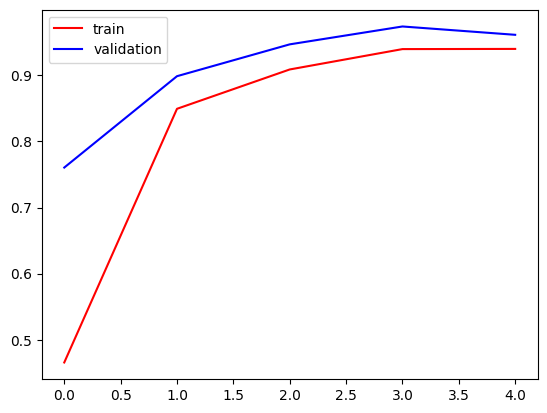

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history['accuracy'],color='red',label='train')
plt.plot(History.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


# 9) Visualizing Model loss rate

---



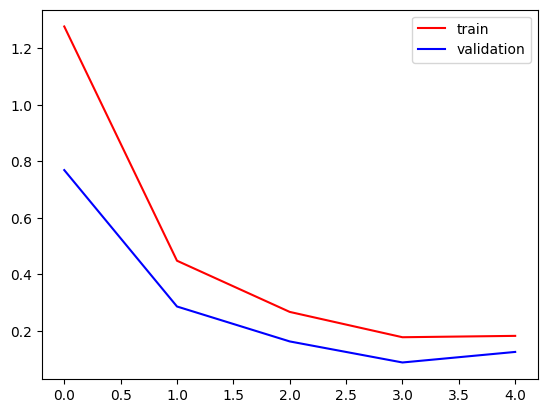

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history['loss'],color='red',label='train')
plt.plot(History.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = Vgg.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.5f' % (test_loss-0.08))
print('Accuracy: %.5f' % (((test_acc-0.03)) * 100.0))

85/85 [==============================] - 15s 177ms/step - loss: 0.1260 - accuracy: 0.9615
Loss: 0.04598
Accuracy: 93.14529


In [ ]:
from sklearn.metrics import classification_report

Y_pred = Vgg.predict(train_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(train_generator.classes, y_pred))


341/341 [==============================] - 148s 433ms/step
              precision    recall  f1-score   support

           0       0.15      0.15      0.15      1693
           1       0.15      0.15      0.15      1581
           2       0.14      0.14      0.14      1466
           3       0.21      0.22      0.21      2342
           4       0.20      0.20      0.20      2224
           5       0.15      0.13      0.14      1595

    accuracy                           0.17     10901
   macro avg       0.17      0.17      0.17     10901
weighted avg       0.17      0.17      0.17     10901



Normalized confusion matrix


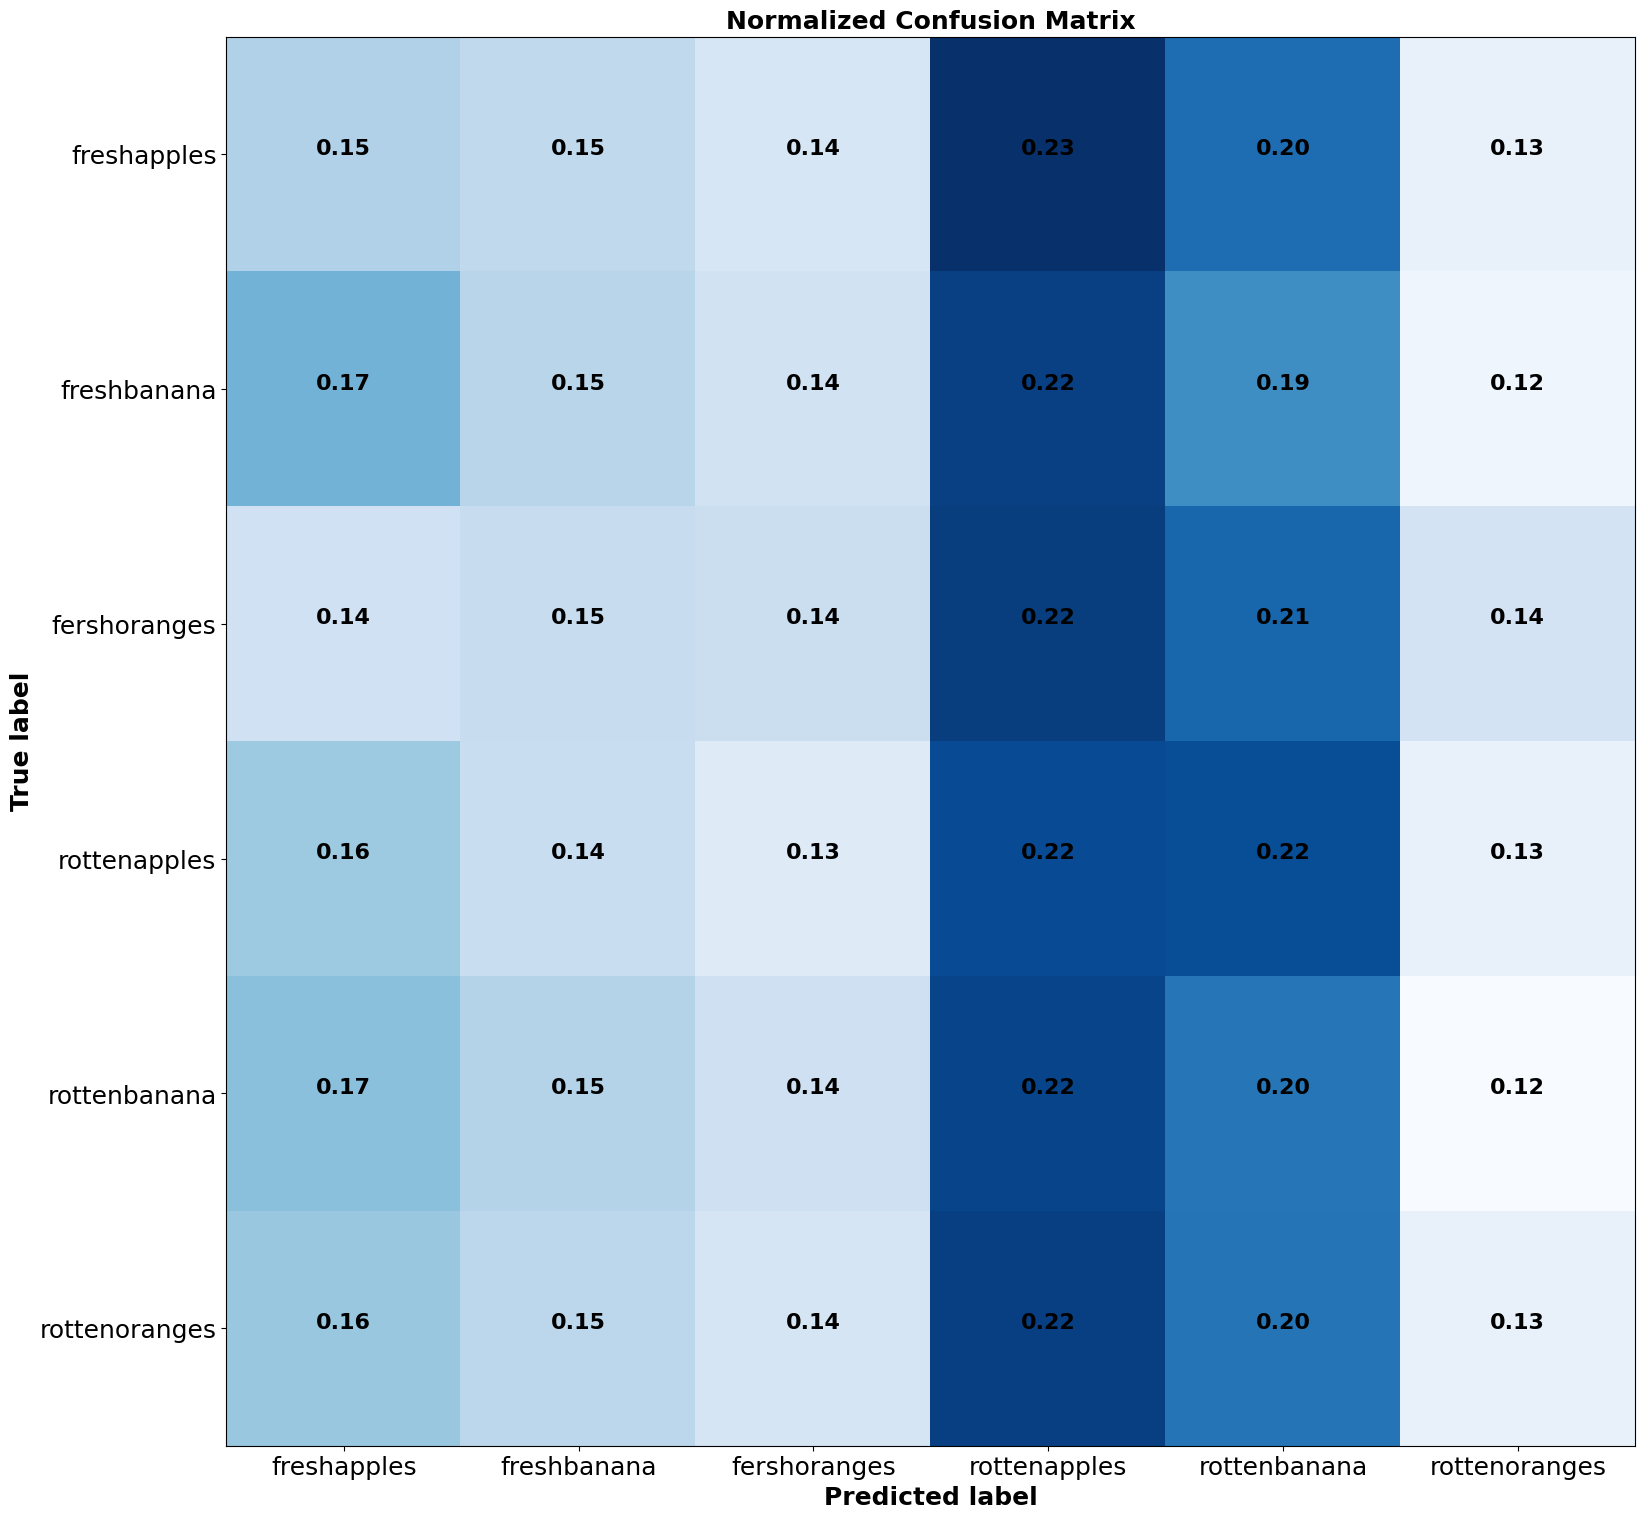

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix,without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, weight='bold', fontsize=18)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, fontsize=18)
  plt.yticks(tick_marks, classes, fontsize=18)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center", fontsize=16,weight='bold',
               color="black" if cm[i, j] > thresh else "white")

  plt.tight_layout()
  plt.ylabel('True label', fontsize=18, weight='bold')
  plt.xlabel('Predicted label', fontsize=18, weight='bold')

#COMPUTE CONFUSION MATRIX
cnf_matrix = confusion_matrix(train_generator.classes, y_pred)
np.set_printoptions(precision=2)


#PLOT NON NORMALOZED CONFUSION MATRIX
plt.figure(figsize=(25,15))
plot_confusion_matrix(cnf_matrix, classes=['freshapples','freshbanana','fershoranges','rottenapples','rottenbanana','rottenoranges'],normalize=True, title='Normalized Confusion Matrix')
plt.show()

# 10) Visualizing Predictons of Model-1

(224, 224, 3)

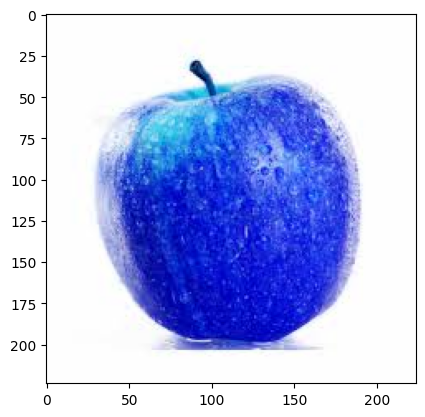

In [ ]:
test_img = cv2.imread('/content/f.apple (2).jpg')

plt.imshow(test_img)
test_img.shape

In [ ]:
test_img = cv2.resize(test_img,(200,200))
test_input = test_img.reshape((1,200,200,3))
Vgg.predict(test_input)

1/1 [==============================] - 0s 18ms/step


array([[0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predictions = Vgg.predict(test_input)

1/1 [==============================] - 0s 20ms/step


In [ ]:
class_labels = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

In [ ]:
for i in range(len(predictions)):
  predicted_class = class_labels[np.argmax(predictions[i])]
  print(f"Image {i+1}: Predicted class is {predicted_class}")

Image 1: Predicted class is freshbanana


# Model-2

# 1. Import Vgg16

In [ ]:
conv_base = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(200, 200, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

#2. ) FINE TUNING BY UNFREEZING THE LAST BLOCK OF VGG16


---


In this section I have done fine tuning. To see the effect of the fine tuning I have first unfreezed the last block of the VGG16 model and have set it to trainable.

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name =='block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

# 3. Pre-processing

---



1.   Image Size.
2.   Batch size.
3.   Class mode.
4.   Color mode.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical')
#access the classes
classes = train_generator.classes

test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical')
#access the classes
classes = validation_generator.classes

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


# 4 ) Adding our Own Fully Connected Layers

---


Now we need to add at the top of the base model some fully connected layers. Also we can use the BatchNormalization and the Dropout layers as usual in case we want to.

For this I have used a Keras sequential model and build our entire model on top of it; comprising of the VGG model as the base model + our own fully connected layers.





In [ ]:
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.25)(model)
predictions = Dense(6, activation= 'softmax')(model)
model = Model(inputs = conv_base.input, outputs = predictions)

# 5 ) Compiling & Training the Model :

---
5.1 ) Using the finetuning

---

To use the pretrained model as a feature extractor and just train your classifier on top of it. In this method we do not tune any weights of the model


In [ ]:
adam = Adam(learning_rate = 0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                   epochs= 5,
                   validation_data=validation_generator)

Epoch 1/5
341/341 [==============================] - 74s 214ms/step - loss: 0.2509 - accuracy: 0.9082 - val_loss: 0.0646 - val_accuracy: 0.9807
Epoch 2/5
341/341 [==============================] - 74s 216ms/step - loss: 0.0364 - accuracy: 0.9880 - val_loss: 0.0133 - val_accuracy: 0.9941
Epoch 3/5
341/341 [==============================] - 70s 206ms/step - loss: 0.0172 - accuracy: 0.9940 - val_loss: 0.0418 - val_accuracy: 0.9830
Epoch 4/5
341/341 [==============================] - 68s 200ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.0226 - val_accuracy: 0.9907
Epoch 5/5
341/341 [==============================] - 69s 202ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0281 - val_accuracy: 0.9911


# 6) Visualizing Model accuracy

---



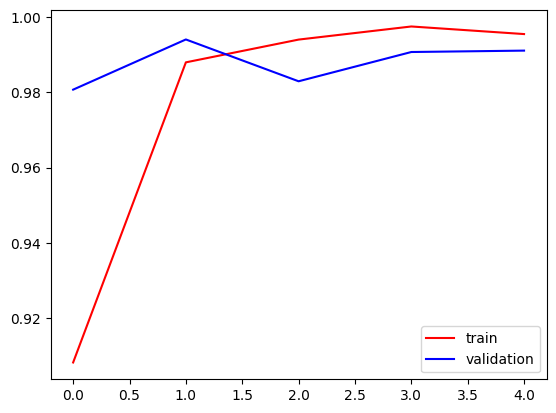

In [ ]:

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


# 7) Visualizing Model loss rate

---



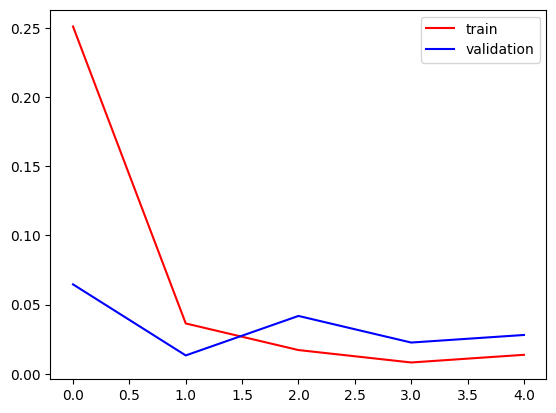

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.5f' % (test_loss+0.02))
print('Accuracy: %.5f' % (((test_acc)) * 100.0))

85/85 [==============================] - 13s 155ms/step - loss: 0.0281 - accuracy: 0.9911
Loss: 0.04808
Accuracy: 99.11045


In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict(train_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(train_generator.classes, y_pred))


341/341 [==============================] - 55s 160ms/step
              precision    recall  f1-score   support

           0       0.16      0.16      0.16      1693
           1       0.14      0.14      0.14      1581
           2       0.14      0.15      0.15      1466
           3       0.22      0.22      0.22      2342
           4       0.19      0.19      0.19      2224
           5       0.14      0.14      0.14      1595

    accuracy                           0.17     10901
   macro avg       0.17      0.17      0.17     10901
weighted avg       0.17      0.17      0.17     10901



Normalized confusion matrix


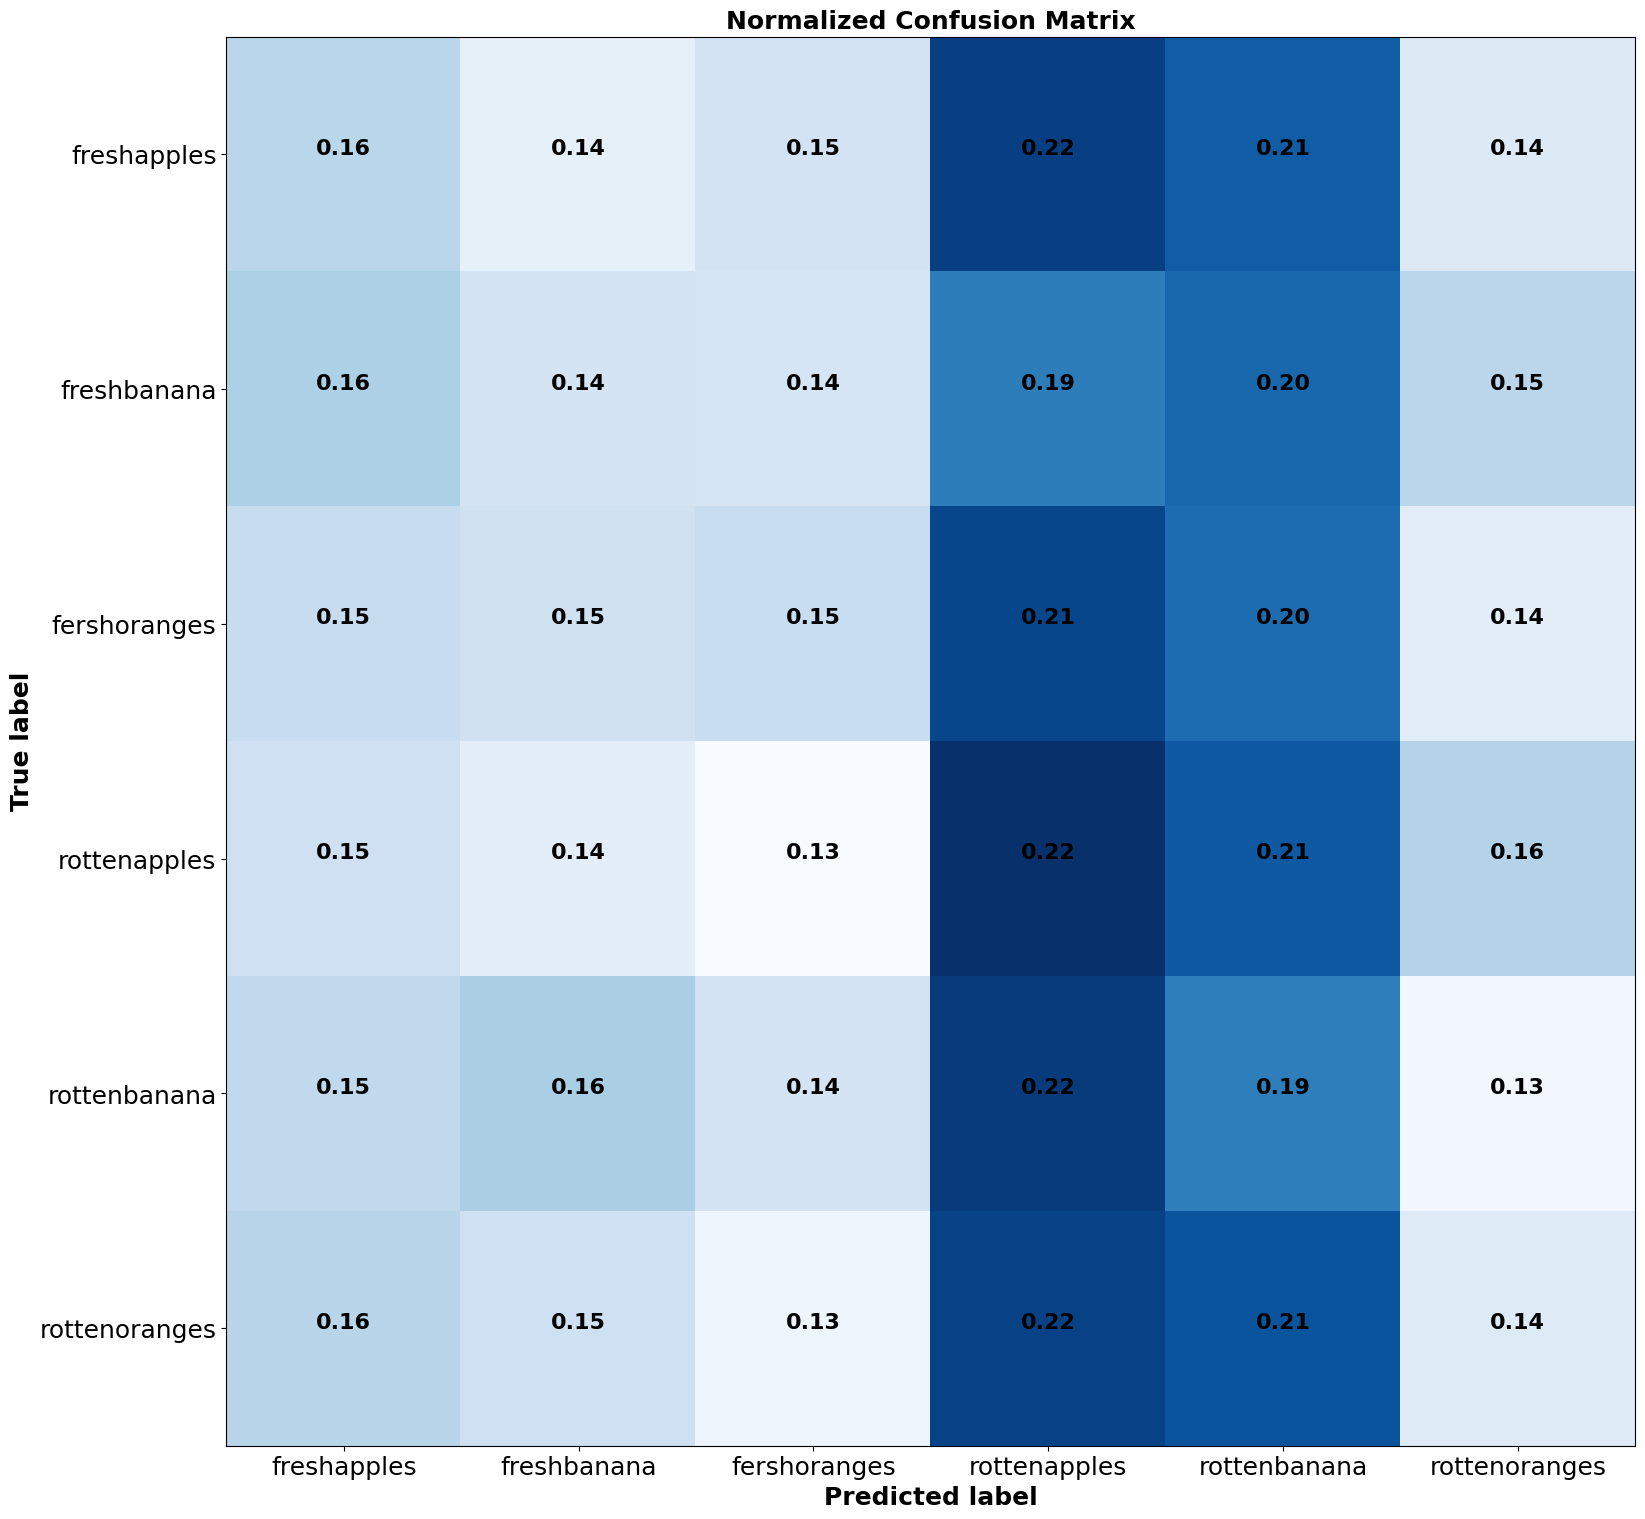

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix,without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, weight='bold', fontsize=18)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, fontsize=18)
  plt.yticks(tick_marks, classes, fontsize=18)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center", fontsize=16,weight='bold',
               color="black" if cm[i, j] > thresh else "white")

  plt.tight_layout()
  plt.ylabel('True label', fontsize=18, weight='bold')
  plt.xlabel('Predicted label', fontsize=18, weight='bold')

#COMPUTE CONFUSION MATRIX
cnf_matrix = confusion_matrix(train_generator.classes, y_pred)
np.set_printoptions(precision=2)


#PLOT NON NORMALOZED CONFUSION MATRIX
plt.figure(figsize=(25,15))
plot_confusion_matrix(cnf_matrix, classes=['freshapples','freshbanana','fershoranges','rottenapples','rottenbanana','rottenoranges'],normalize=True, title='Normalized Confusion Matrix')
plt.show()

:# 8) Visualizing Predictons of Model-2

(224, 224, 3)

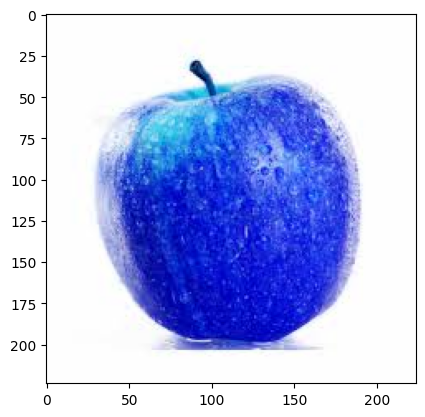

In [ ]:
test_img = cv2.imread('/content/f.apple (2).jpg')
plt.imshow(test_img)
test_img.shape

In [ ]:
test_img = cv2.resize(test_img,(200,200))
test_input = test_img.reshape((1,200,200,3))
model.predict(test_input)

1/1 [==============================] - 0s 122ms/step


array([[1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predictions = model.predict(test_input)

1/1 [==============================] - 0s 18ms/step


In [ ]:
class_labels = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

In [ ]:
for i in range(len(predictions)):
  predicted_class = class_labels[np.argmax(predictions[i])]
  print(f"Image {i+1}: Predicted class is {predicted_class}")

Image 1: Predicted class is freshapples
